# 6-量子アニーリングによる機械学習

このチュートリアルでは、量子アニーリングの最適化の応用の一例として機械学習(クラスタリング、Qboost)を取り上げます。  
まず、前半部分ではPyQUBOとOpenjijを利用したクラスタリングを行います。  
後半では、PyQUBOとD-Waveのサンプラーを用いてQboostというアンサンブル学習を行います。


## クラスタリング

クラスタリングとは与えられたデータを 𝑛 個のクラスターに分けるというタスクです。( 𝑛 は外部から与えられているとします。)
今回は　クラスター数が2の場合を考えていきます。

In [1]:
# ライブラリのインポート
import numpy as np
from matplotlib import pyplot as plt
from sklearn import cluster
import pandas as pd
from scipy.spatial import distance_matrix 
from pyqubo import Array, Constraint, Placeholder, solve_qubo
import openjij as oj

### 人工データを作成する

今回は人工的に、二次元平面上の明らかに線形分離可能なデータを生成し、それをクラスタリングします。

In [2]:
data = []
label = []
for i in range(100):
    p = np.random.uniform(0, 1)
    cls =1 if p>0.5 else -1
    data.append(np.random.normal(0, 0.5, 2) + np.array([cls, cls]))
    label.append(cls)
    
df1 = pd.DataFrame(data, columns=["x", "y"], index=range(len(data)))
df1["label"] = label

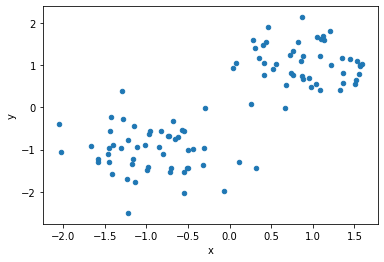

In [3]:
# データセットの確認
df1.plot(kind='scatter', x="x", y="y")
plt.show()

今回は、以下のハミルトニアンを最小化することでクラスタリングを行います。

$$
H = - \sum_{i, j} \frac{1}{2}d_{i,j}(1 - \sigma _i \sigma_j)
$$


$i, j$はサンプルの番号、$d_{i,j}$は２つのサンプル間の距離、$\sigma_i=\{-1,1\}$です。この$\sigma _i $は２つのクラスターのどちらかに属しているかを表しています。
このハミルトニアンの和の各項は   
- $\sigma_i  = \sigma_j $のとき、0
- $\sigma_i  \neq \sigma_j $のとき、$d_{i,j}$  

になるので、右辺のマイナスに注意すると、ハミルトニアン全体では「異なるクラスに属しているサンプル同士の距離を最大にする$\{\sigma _1, \sigma _2 \ldots \}$の組を選べ 」という問題に帰着することがわかります。

###  PyQUBOによるクラスタリング

まずは、PyQUBOで上のハミルトニアンを定式化し、さらに、 ``solve_qubo``を用いてシュミレーテッドアニーリングを行います。

In [4]:
def clustering_pyqubo(df):
    # 距離行列
    d_ij = distance_matrix(df, df)

    # spin
    spin = Array.create("spin", shape= len(df), vartype="SPIN")

    # ハミルトニアン
    H = - 0.5* sum(
        [d_ij[i,j]* (1 - spin[i]* spin[j]) for i in range(len(df)) for j in range(len(df))]
    )

    model = H.compile()
    qubo, offset = model.to_qubo()
    # 解を求める
    raw_solution = solve_qubo(qubo, num_reads=10)

    decoded_solution, broken, energy= model.decode_solution(raw_solution, vartype="SPIN")

    labels = [decoded_solution["spin"][idx] for idx  in range(len(df))]
    return labels, energy

In [5]:
labels, energy =clustering_pyqubo(df1[["x", "y"]])
print("label", labels)
print("energy", energy)

label [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
energy -8098.296906302581


可視化をしてみましょう

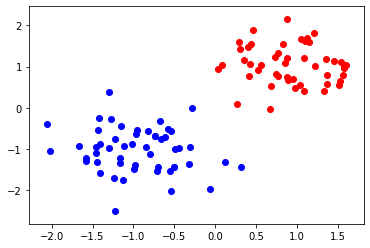

In [6]:
for idx, label in  enumerate(labels):
    if label:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="b")  
    else:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="r")

## Openjijのソルバーを用いたクラスタリング

次はOpenjijのソルバーを用いてクラスタリングをしてみましょう。なお、QUBOの定式化のためにPyQUBOも併用します。

In [7]:
def clustering_openjij(df):
    # 距離行列
    d_ij = distance_matrix(df, df)

    # spin
    spin = Array.create("spin", shape= len(df), vartype="SPIN")

    # ハミルトニアン
    H = - 0.5* sum(
        [d_ij[i,j]* (1 - spin[i]* spin[j]) for i in range(len(df)) for j in range(len(df))]
    )

    model = H.compile()
    qubo, offset = model.to_qubo()
    # 解を求める
    sampler = oj.SQASampler(iteration=10, step_num=100)
    response = sampler.sample_qubo(qubo)
    raw_solution = dict(zip(response.indices, response.states[np.argmin(response.energies)]))


    decoded_solution, broken, energy= model.decode_solution(raw_solution, vartype="SPIN")
    labels = [int(decoded_solution["spin"][idx] ) for idx  in range(len(df))]
    return labels,  sum(response.energies)

In [8]:
labels, energy =clustering_openjij(df1[["x", "y"]])

print("label", labels)
print("energy", energy)

label [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
energy -143516.3648495398


こちらも、可視化をしてみましょう。

In [ ]:
for idx, label in  enumerate(labels):
    if label:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="b")  
    else:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="r")

## QBoost

QBoostは量子アニーリングを用いたアンサンブル学習の一つです。  
アンサンブル学習は弱い予測器を多数用意して、その予測器の各予測結果の組み合わせて最終的な予測結果を得ます。 
  
QBoostでは、与えられた学習データに対して最適な学習器の組み合わせを量子アニーリングを用いて最適化します。今回は分類問題を扱います。  
まず、$D$個の学習データの集合を$\{\vec x^{(d)}\}(d=1, ..., D)$、対応するラベルを$\{y^{(d)}\}(d=1, ..., D), y^{(d)}\in \{-1, 1\}$とします。また、$N$個の弱学習器の（関数の）集合を$\{C_i\}(i=1, ..., N)$とします。なお、あるデータ$\vec x^{(d)}$　に対して、$C_i(\vec x^{(d)})\in \{-1, 1\}$です。このとき、最終的な分類のラベルは以下のようになります。
$$y_d ={\rm sgn}\left( \sum_{i=1}^{N} w_i C_i(x_d)\right)  $$
ただし、$w_i\in\{0, 1\} (N=1, ..., N)$とし、各予測器の重み(予測器を最終的な予測に採用するか採用しないかのbool値)とします。  
QBoostではこの$w_i$を弱学習器の個数を刈り込みつつ、最終的な予測が教師データに一致する組み合わせを最適化を行います。
この問題におけるハミルトニアンは、以下のようになります。
$$H(\vec w) = \sum_{d=1}^{D} \left( \frac{1}{N}\sum_{i=1}^{N} w_i C_i(\vec x^{(d)}) \right)^2 + \lambda \sum _i^N w_i$$
このハミルトニアンのだいい